# 目标检测  SSD 算法

----------------------------------------------
准备数据 
==============================================

如何使用AWS deepling AMI 进行深度学习， 请参考 [https://github.com/dikers/aws-workshop-sample/tree/master/aws-deep-learning-ami](https://github.com/dikers/aws-workshop-sample/tree/master/aws-deep-learning-ami)


### 第一步 准备图片

录制需要识别物体的视频， 或者直接拍摄图片

安装ffmpeg   
```
ffmpeg -ss 00:00 -i test.mov -f image2  -s 640x426 -r 1 -t 01:00 test_%3d.jpg
 
-ss 开始时间
-i  视频路径
-f  类型
-s  大小
-r   速率， 每秒一张图片
-t 结束时间
201_%3d.jpg  对图片进行命名

```

将所有的图片放置到指定文件夹 raw-data/JPEGImages/
```shell
raw-data/
    JPEGImages/   #所有图片
    Annotations/  #所有xml标记信息
```

然后进行打标签工作


### 第二步 打标签

打标签工具下载地址
[项目地址](https://github.com/wkentaro/labelme)

```
git clone https://github.com/wkentaro/labelme.git
cd ./labelImg
```

修改标签数据
```
vim ./data/predefined_classes.txt


```

执行代码
```
python labelImg.py
```



![image](http://raw.githubusercontent.com/tzutalin/labelImg/master/demo/demo3.jpg)

```
Ctrl + u	Load all of the images from a directory
Ctrl + r	Change the default annotation target dir
Ctrl + s	Save
Ctrl + d	Copy the current label and rect box
Space	Flag the current image as verified
w	Create a rect box
d	Next image
a	Previous image
del	Delete the selected rect box
Ctrl++	Zoom in
Ctrl--	Zoom out
↑→↓←	Keyboard arrows to move selected rect box
```


分别设置图片的文件夹位置  和生成的xml保存路径， 然后进行打标签工作。 


### 第三步  上传图片和xml标签数据到服务器

图片上传路径        base_dir + 'JPEGImages/' 

标记数据上传路径     base_dir + 'Annotations/' 


将本地图片和xml 标记数据 压缩， 然后上传到服务器上

```shell
#压缩本地文件 zip 格式
zip -r raw-data.zip  raw-data/
scp  -i "~/bin/key.pem"  raw-data.zip  ec2-user@ip_adress:/home/ec2-user/examples/object_detection_image_ssd/
```

登录到服务器

```shell

cd /home/ec2-user/examples/object_detection_image_ssd/
rm -fr raw-data
unzip raw-data.zip
```
新建好的路径如下： 
```
object_detection_image_ssd/
    raw-data/
        JPEGImages/   #所有图片
        Annotations/  #所有xml标记信息

```



In [12]:
# 导入数据
import numpy as np
import os
from xml.etree import ElementTree
import json

# 修改成自己的根路径
base_dir = './raw-data/'

# 将图片保存到以下文件夹下面
image_save_path = os.path.join(base_dir , 'JPEGImages/') 
annotations_save_path = os.path.join(base_dir + 'Annotations/') 
label_list = ['401', '402', '403', '201', '202', '101', '102', '103', '105', '106', '107', '301', '302']



In [13]:
val_ratio = 0.25
test_ratio = 0.05




imagesets_path = base_dir + 'Imagesets/'
if not os.path.exists(imagesets_path): 
    os.mkdir(imagesets_path)

layout_path = base_dir + 'Imagesets/Layout/'
if not os.path.exists(layout_path): 
    os.mkdir(layout_path)

main_path = base_dir + 'Imagesets/Main/'
if not os.path.exists(main_path): 
    os.mkdir(main_path)
    
json_save_path = base_dir + 'json/'
if not os.path.exists(json_save_path): 
    os.mkdir(json_save_path)


# Sagemaker 所需要的数据集
sagemaker_path = base_dir + 'sagemaker/'

if not os.path.exists(sagemaker_path): 
    os.mkdir(sagemaker_path)

train_path = sagemaker_path + 'train/'
if not os.path.exists(train_path): 
    os.mkdir(train_path)
    
train_annotation_path = sagemaker_path + 'train_annotation/'
if not os.path.exists(train_annotation_path): 
    os.mkdir(train_annotation_path)
    
validation_path = sagemaker_path + 'validation/'
if not os.path.exists(validation_path): 
    os.mkdir(validation_path)
    
validation_annotation_path = sagemaker_path + 'validation_annotation/'
if not os.path.exists(validation_annotation_path): 
    os.mkdir(validation_annotation_path)


### 第四步  划分训练 验证 测试数据集

In [14]:
class XML_preprocessor(object):

    def __init__(self, data_path, label_list, json_save_path):
        self.path_prefix = data_path
        self.num_classes = len(label_list)
        self.data = dict()
        self._label_list = label_list
        self._json_save_path = json_save_path
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:

            if filename.startswith('.'):
                continue
            if not filename.endswith('.xml'):
                continue


            tree = ElementTree.parse(self.path_prefix + filename)
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    xmin = float(bounding_box.find('xmin').text)/width
                    ymin = float(bounding_box.find('ymin').text)/height
                    xmax = float(bounding_box.find('xmax').text)/width
                    ymax = float(bounding_box.find('ymax').text)/height
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            image_name = root.find('filename').text
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data

    def _to_one_hot(self,name):
        one_hot_vector = [0] * self.num_classes

        _index = self._label_list.index(name)

        if _index < 0:
            print('Annotations 中的label 和配置文件中 不一致 unknown label: %s' % name)
        one_hot_vector[_index] = 1
        return one_hot_vector

    def _save_file(self, json_object, path):
        with open(path, "w") as f:
            json.dump(json_object, f)

        
    def to_json(self):
        """
        生成sagemaker 使用的json 文件
        """
        train_val_list = list()

        filenames = os.listdir(self.path_prefix)

        for filename in filenames:

            if filename.startswith('.'):
                continue
            if not filename.endswith('.xml'):
                continue

            json_object = dict()
            tree = ElementTree.parse(self.path_prefix + filename)
            root = tree.getroot()
            size_tree = root.find('size')
            image_name = root.find('filename').text
            json_object['file'] = image_name

            width = int(size_tree.find('width').text)
            height = int(size_tree.find('height').text)

            annotations = list()
            categories = list()

            for object_tree in root.findall('object'):

                annotation = dict()
                category = dict()
                _top = 0
                _left = 0
                _width = 0
                _height = 0

                for bounding_box in object_tree.iter('bndbox'):
                    _top = int(bounding_box.find('ymin').text)
                    _left = int(bounding_box.find('xmin').text)
                    _width = int(bounding_box.find('xmax').text) - _left
                    _height = int(bounding_box.find('ymax').text) - _top


                class_name = object_tree.find('name').text

                class_id = self._label_list.index(class_name)
                if class_id < 0:
                    print('Annotations 中的label 和配置文件中 不一致 unknown label: %s' % class_name)
                annotation['class_id'] = class_id
                annotation['top'] = _top
                annotation['left'] = _left
                annotation['width'] = _width
                annotation['height'] = _height
                category['class_id'] = class_id
                category['name'] = class_name
                train_val = dict()
                train_val['name'] = image_name.split('.')[0]
                train_val['label'] = class_id + 1
                train_val_list.append(train_val)


                annotations.append(annotation)
                categories.append(category)

            image_list = list()
            image_size = dict()
            image_size['width'] = width
            image_size['height'] = height
            image_size['depth'] = 3
            image_list.append(image_size)

            json_object['image_size']= image_list
            json_object['annotations'] = annotations
            json_object['categories'] = categories

            path = self._json_save_path + image_name.split('.')[0] +'.json'
            self._save_file(json_object, path)

        return train_val_list



In [45]:
import shutil
def splite_test_data(test_data):
    

    if not os.path.exists(test_annotations_dir): 
        os.mkdir(test_annotations_dir)

    if not os.path.exists(test_images_dir): 
        os.mkdir(test_images_dir)


    for item in test_data:
        print('{}{}.xml'.format(annotations_save_path, item['name']), '{}{}.jpg'.format(image_save_path, item['name']))
        shutil.move('{}{}.jpg'.format(image_save_path, item['name']), test_images_dir)
        shutil.move('{}{}.xml'.format(annotations_save_path, item['name']), test_annotations_dir)
        



In [48]:
import random
test_images_dir = os.path.join(base_dir + 'test_images/') 
test_annotations_dir = os.path.join(base_dir + 'test_annotations/') 



xml = XML_preprocessor(annotations_save_path, label_list, json_save_path)
all_data = xml.to_json()
data_length = len(all_data)
random.shuffle(all_data)

if not os.path.exists(test_annotations_dir): 
    print('样本数量    :', len(all_data))
    test_count = int(data_length * test_ratio)
    test_list = all_data[0:test_count]
    all_data = all_data[test_count:]

    splite_test_data(test_list)
    print('第一次划分的测试集数量 {}  训练集数量{}'.format(test_count, len(all_data)))
else:
    print('已经划分的测试集合， 如果要再次划分， 请删除文件夹{}'.format(test_images_dir))
### 第二次划分

data_length = len(all_data)
val_count = int(data_length * val_ratio)
test_count = int(data_length * test_ratio)

val_list =  all_data[0:val_count]
test_list =  all_data[val_count: val_count+test_count]
train_list = all_data[val_count+test_count:]

print('验证集数量  :', len(val_list))
print('测试集数量  :', len(test_list))
print('训练集数量  :', len(train_list))


def dict_to_set(list_dict):
    result_set = set()
    for i in list_dict:
        result_set.add(i['name'])
    return result_set


dict_to_set(val_list)

def write_list_to_file(_list, file_path):
    with open(file_path, "w") as f:
        for i in _list:
            f.write('{} {}\n'.format(i['name'], i['label']))

def write_set_to_file(_set, file_path):
    with open(file_path, "w") as f:
        for i in _set:
            f.write('{}\n'.format(i))            
            
            





已经划分的测试集合， 如果要再次划分， 请删除文件夹./raw-data/test_images/
验证集数量  : 138
测试集数量  : 27
训练集数量  : 388


In [18]:
write_list_to_file(train_list, layout_path + 'train.txt')
write_list_to_file(val_list, layout_path + 'trainval.txt')
write_list_to_file(test_list, layout_path + 'val.txt')

write_set_to_file(dict_to_set(train_list), main_path + 'train.txt')
write_set_to_file(dict_to_set(val_list), main_path + 'trainval.txt')
write_set_to_file(dict_to_set(test_list), main_path + 'val.txt')



### 第五步   将数据写入到sagemaker文件夹里， 供sagemaker训练使用

In [25]:
from shutil import copyfile
from shutil import move
train_set = dict_to_set(train_list)
val_set = dict_to_set(val_list)
test_set = dict_to_set(test_list)

for item in train_set:
    copyfile('{}{}.jpg'.format(image_save_path, item) ,'{}{}.jpg'.format(train_path, item) )
    copyfile('{}{}.json'.format(json_save_path, item) ,'{}{}.json'.format(train_annotation_path, item) )
    

for item in val_set:
    copyfile('{}{}.jpg'.format(image_save_path, item) ,'{}{}.jpg'.format(validation_path, item) )
    copyfile('{}{}.json'.format(json_save_path, item) ,'{}{}.json'.format(validation_annotation_path, item) )


### 第六步 划分测试集

--------------------------------------------------------------------
开始训练
==================================================================





In [5]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle


from SSD300.ssd_v2 import SSD300v2
from SSD300.ssd_training import MultiboxLoss
from SSD300.ssd_utils import BBoxUtility

from SSD300.get_data_from_XML import XML_preprocessor
from SSD300.generator import Generator

NUM_CLASSES = len(label_list) + 1
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer='Adadelta', loss=loss)


priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

Using TensorFlow backend.







Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




In [ ]:
pascal_voc_07_parser = XML_preprocessor(data_path=annotations_save_path , label_list=label_list)
# len(pascal_voc_07_parser.data) = 5011

# pascal_voc_07_parser.data['000007.jpg']
# array([[ 0.282     ,  0.15015015,  1.        ,  0.99099099,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ]])

keys = list(pascal_voc_07_parser.data.keys())
train_num = int(0.7 * len(keys))
train_keys = keys[:train_num]
val_keys = keys[train_num:]

gen = Generator(gt=pascal_voc_07_parser.data, bbox_util=bbox_util,
                 batch_size=16, path_prefix= image_save_path,
                 train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))


keys = list(pascal_voc_07_parser.data.keys())
print(keys[0:10])
print(pascal_voc_07_parser.data[keys[1]])

In [ ]:
RUN = RUN + 1 if 'RUN' in locals() else 1

LOG_DIR = './output/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

EPOCHS = 30

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches ),
                              validation_data=gen.generate(False), validation_steps=int(gen.val_batches),
                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping])

-----------------------------------------
测试模型
===========================================

In [7]:
model.load_weights('./output/checkpoint-19-0.8947.hdf5', by_name=True)

### 读取测试数据


In [54]:
def read_images_list():
    filenames = os.listdir(test_images_dir)
    image_list = []
    for filename in filenames:
        if filename.startswith('.'):
            continue
        if not filename.endswith('.jpg') and not filename.endswith('.jpeg'):
            continue
        print('{}{}'.format(test_images_dir, filename))
        image_list.append('{}{}'.format(test_images_dir, filename))
    return image_list

In [55]:
from keras.preprocessing import image
from imageio import imread
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

filename = base_dir + 'Imagesets/Main/val.txt'
files = read_images_list()
        
inputs = []
images = []

for f in files:
    img = image.load_img(""+f, target_size=(300, 300))
    img = image.img_to_array(img)
    
    images.append(imread(f))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
# preds.shape (5, 7308, 33)

results = bbox_util.detection_out(preds)
# type(results): list, len(results): 5, len(result[0]): 200, results[0].shape: (200, 6)

./raw-data/test_images/1_017.jpg
./raw-data/test_images/4_031.jpg
./raw-data/test_images/6_040.jpg
./raw-data/test_images/5_009.jpg
./raw-data/test_images/4_030.jpg
./raw-data/test_images/5_031.jpg
./raw-data/test_images/4_037.jpg
./raw-data/test_images/5_032.jpg
./raw-data/test_images/5_027.jpg
./raw-data/test_images/203_017.jpg
./raw-data/test_images/203_010.jpg
./raw-data/test_images/202_031.jpg
./raw-data/test_images/6_001.jpg
./raw-data/test_images/6_014.jpg
./raw-data/test_images/6_003.jpg
./raw-data/test_images/3_026.jpg
./raw-data/test_images/202_033.jpg
./raw-data/test_images/2_024.jpg
./raw-data/test_images/6_004.jpg
./raw-data/test_images/4_007.jpg
./raw-data/test_images/4_013.jpg
./raw-data/test_images/5_016.jpg
./raw-data/test_images/204_002.jpg
./raw-data/test_images/5_029.jpg
./raw-data/test_images/204_001.jpg
./raw-data/test_images/4_029.jpg
./raw-data/test_images/5_004.jpg
./raw-data/test_images/204_010.jpg
./raw-data/test_images/4_014.jpg
./raw-data/test_images/201_02

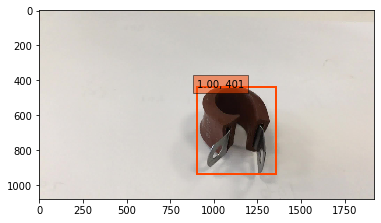

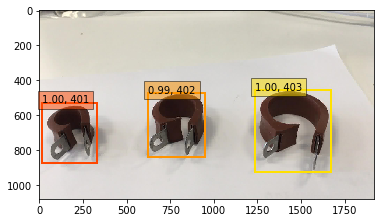

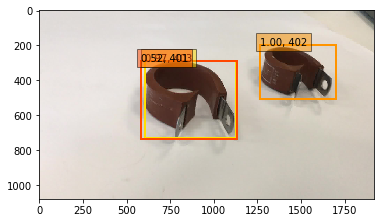

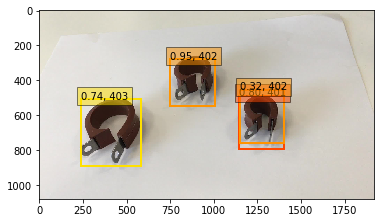

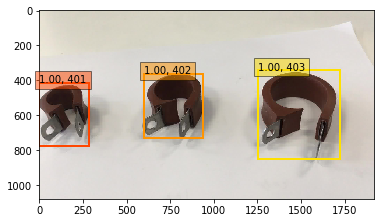

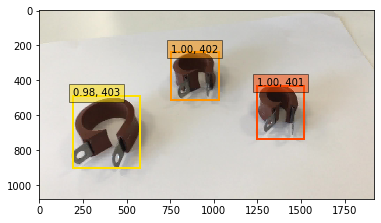

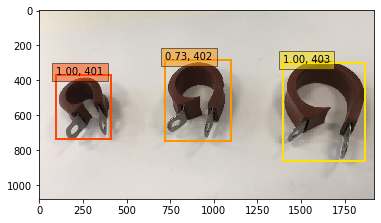

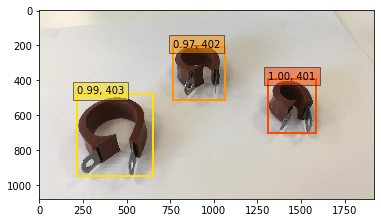

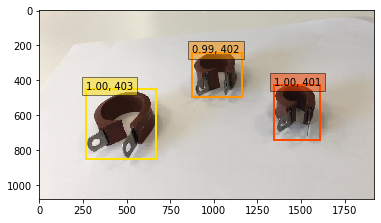

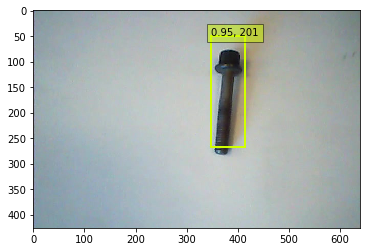

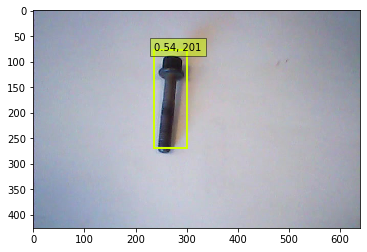

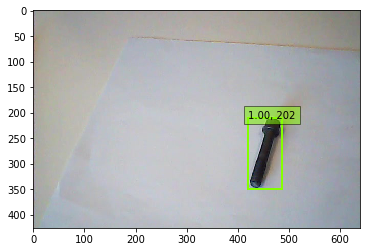

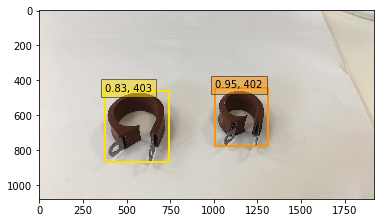

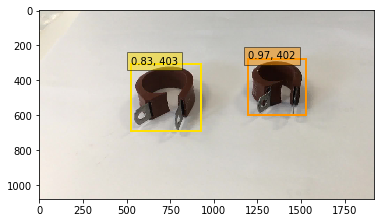

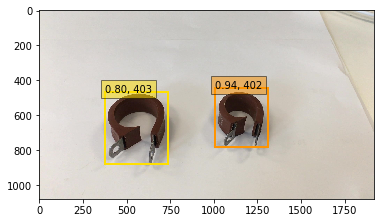

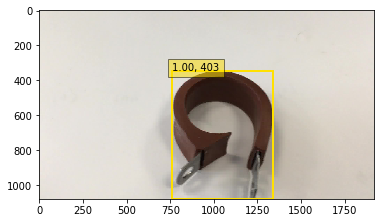

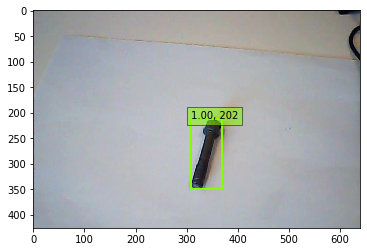

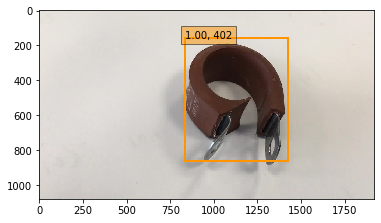

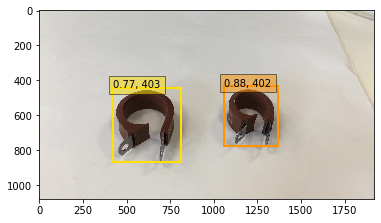

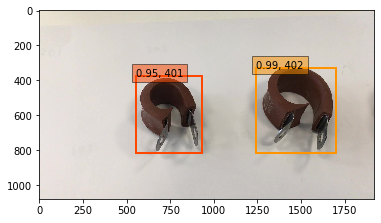

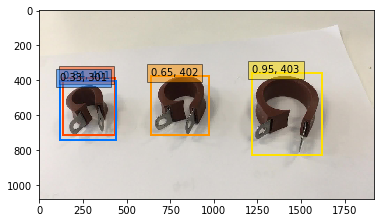

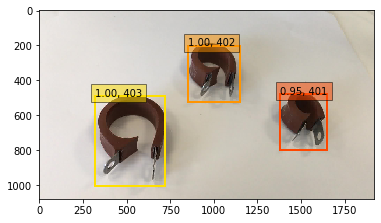

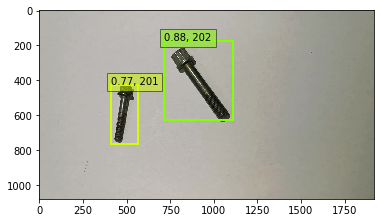

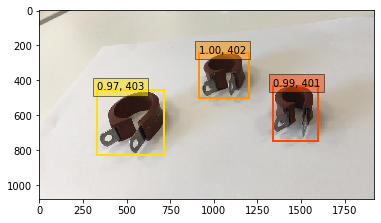

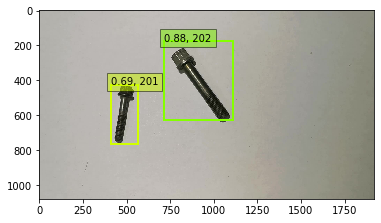

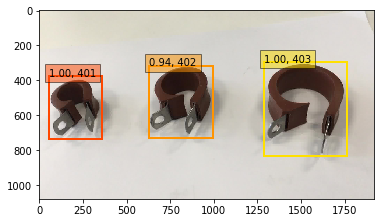

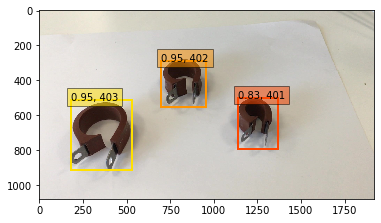

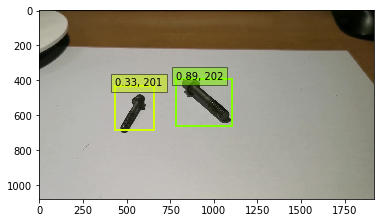

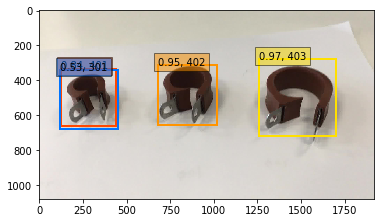

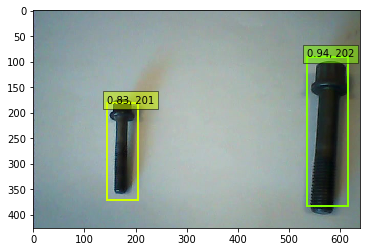

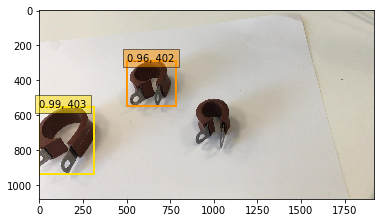

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.3]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = label_list[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()